In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

Nodeと面は違うよね、  
温度はNodeごとに定義するんじゃない？じゃあ、Nodeの中にいくつかの面が取り込まれる方式になるはず、いやこれも違う、Nodeは面と独立,　面は方向を持つけど、それぞれの面がどのノードに属しているかの情報が必要  
Node間の関係はグラフ理論のやつ使ったらえんかな、データ構造的に工夫して格納しても良いけど  
Environmentはどうしよ、全体として  

熱源：外部は，熱入力、その方向を持つ  
    内部はSCが持って、熱入力、どのノードか？ これはまたあとで

基本的に熱平衡方程式は各ノード間、

各面に対するノードidは面の定義のときに入力させる

外部熱入力に関してメモ：

In [2]:
#CubeSatを仮定
class Spacecraft:
    def __init__(self, node_num, size, surface_char, surface_name_id, mass):
        self.node_number = node_num
        self.size = size #sizeは小さい順に入力
        self.areas = 0
        self.surface_characteristics = surface_char
        self.node_id = list(surface_name_id.values())
        self.mass = mass #kg
        self.surface_name = list(surface_name_id.keys()) #["px", "py", "pz", "mx", "my", "mz"]
        self.node = [] #nodeはリスト。温度、各ノード間の熱コンダクタンス、形態係数
    #directionは小さい面から順にx,y,zとする
    def sc_area(self):
        l0, l1, l2 = self.size
        return (l0*l1, l0*l2, l1*l2)
    #伝達係数，形態係数は行列で与える
    def ini_node(self, temperature, conductance, form_factor, heat_capacity): 
        for i in range(self.node_number):
            capa = self.mass*heat_capacity[i]
            self.node.append({"temperature" : temperature[i], "conductance" : conductance[i], "form_factor" : form_factor[i], "heat_capacity" : capa})
            
    #name_idは{name, id}の辞書型
    #面の名前：面積，方向, 表面特性(α，ε)、ノードid
    def ini_surface(self):
        area = self.sc_area()*2
        #これは法線ベクトルで表記(座標系は宇宙機固定)
        direction = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)]
        surface = {}
        for i in range(len(self.surface_name)):
            surface[self.surface_name[i]] = {"area":area[i], "direction":direction[i], "node_id" : self.node_id[i], "surface_char":self.surface_characteristics[i]}
            self.areas = self.areas + area[i]
        return surface    
        
class Environment:
    def __init__(self, node_num):
        self.node_number = node_num
        self.node = []
        
    def ini_node(self, temperature, conductance, form_factor):
        for i in range(self.node_number):
            self.node.append({"temperature" : temperature[i], "conductance" : conductance[i], "form_factor" : form_factor[i]})

#ノードを辞書にしとけば方程式に与える時に求めるもの以外のノードをすぐに探せるから要修正
class Node:
    def __init__(self, spacecraft, environment):
        self.all = spacecraft.node + environment.node
        self.node_number = spacecraft.node_number + environment.node_number

class Thermal_equation:
    def __init__(self, SC, node_id, Env, dt, step, outer_heat):
        self.Node_i = SC.node[node_id]
        self.i = node_id
        self.SC_surface = SC.ini_surface()
        self.SC_areas = SC.areas
        self.Node_j = Env.node
        self.N = Env.node_number
        self.dt = dt
        self.step = step
        self.T = dt*step
        self.k = 0 #Runge_Kuttaの係数
        self.outer_heat = outer_heat
        
    def f(self):
        sigma = 5.67 * 10**(-8)
        trans_sum = 0
        radiation_sum = 0
        #熱伝達と輻射量を計算
        epsiron = self.SC_surface["px"]["surface_char"][1] #これは仮おき、不適切
        #print(epsiron)
        for j in range(self.N):
            trans_sum = trans_sum + self.Node_i["conductance"][j]*(self.Node_i["temperature"] + self.k - self.Node_j[j]["temperature"])
            radiation_sum = radiation_sum + epsiron*sigma*self.Node_i["form_factor"][j]*((self.Node_i["temperature"] + self.k)**4 - self.Node_j[j]["temperature"]**4)
        #外部熱入力を計算
        Qin = 0
        for q in self.outer_heat:
            for S in self.SC_surface.values(): #各面の情報を取り出す
                if self.i == S["node_id"]: #計算するNodeが一致しているときだけ計算する
                    N_direction = S["direction"]
                    q_dot_n =0 #Fluxベクトルと面の法線ベクトルの内積を初期化
                    for i,j in zip(q["direction"], N_direction):
                        q_dot_n = q_dot_n + i*j #Fluxベクトルと面の法線ベクトルの内積
                    if q_dot_n < 0: #内積が負のときは入力がある
                        Qin = Qin - q["q"]*q_dot_n*S["area"]*S["surface_char"][0]
                        #print(S["area"])
                    else:
                        Qin = Qin
        return (Qin - trans_sum - radiation_sum*self.SC_areas)/self.Node_i["heat_capacity"] 
    
    #定常
    #def Newton_method(self):    

    def Euler(self):
        Ti = np.empty(self.step)
        for i in range(self.step):
            Ti[i] = self.Node_i["temperature"]
            self.Node_i["temperature"] = self.Node_i["temperature"] + self.f()*self.dt
        return Ti
        
    def RungeKutta4(self):
        Ti = np.empty(self.step)
            #今はまだオイラー
        for i in range(self.step):
            Ti[i] = self.Node_i["temperature"]
            k1 = self.dt*self.f()
            self.k = k1/2
            k2 = self.dt*self.f()
            self.k = k2/2
            k3 = self.dt*self.f()
            self.k = k3
            k4 = self.dt*self.f()
            dT = (k1 + 2*k2 + 2*k3 + k4)/6
            self.Node_i["temperature"] = self.Node_i["temperature"] + dT
        return Ti

        
def Plot(Ti):
    plt.xlabel("time[s]")
    plt.ylabel("T[K]")
    plt.plot(Ti)
    plt.savefig("figure/T.png")

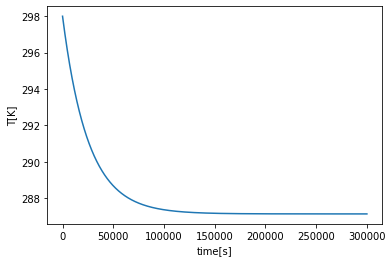

In [6]:
SC_node_num = 1 #number of Node
size = (0.10, 0.20, 0.30) #m 6U
SC_temperature = (25.0 + 273,) #K
#Aluminium
#SC_surface_char = [(0.379, 0.0346), (0.379, 0.0346), (0.379, 0.0346), (0.379, 0.0346), (0.379, 0.0346), (0.379, 0.0346)]
SC_surface_char = [(0.3, 0.29), (0.3, 0.29), (0.3, 0.29), (0.3, 0.29), (0.3, 0.29), (0.3, 0.29)]
SC_conductance = [[0]] #W/K
form_factor = [[1]]
SC_suface = {"px" : 0, "py" : 0, "pz" : 0, "mx" : 0, "my" : 0, "mz" : 0}
SC_heat_capa = [900] #J/(kg・K)
SC_mass = 10#kg
Unv_node_num = 1
Unv_temperature = (-270 + 273,) #K
Unv_conductance = [0]


#太陽方向と入力熱量
phi = 0 # deg
theta = 0 # deg
phi_rad = radians(phi)
theta_rad = radians(theta)
sun = {"q" : 1366, "direction" : (sin(phi_rad)*cos(theta_rad), sin(phi_rad)*sin(theta_rad), cos(phi_rad))} # W/m2, (x,y,z)大きさは1とする
outer_heat = [sun]

dt = 1 #[s]
step = 300000

SC = Spacecraft(SC_node_num, size, SC_surface_char, SC_suface, SC_mass)
SC.ini_node(SC_temperature, SC_conductance, form_factor, SC_heat_capa)
#print(SC.node)
Unv = Environment(Unv_node_num)
Unv.ini_node(Unv_temperature, Unv_conductance, form_factor)
#Node()
Ther_eq = Thermal_equation(SC, 0, Unv, dt, step, outer_heat)
#print(Ther_eq.f())
Plot(Ther_eq.RungeKutta4())
